In [ ]:
#In this notebook we will run SSL algorithms for general x, then we will compare the generalization dynamic for both
#our mathematical result and the result we got from simulation

In this notebook we assume no manifold structure of $x$. True model $y = Xw_{true} + \epsilon$  and  $w_{true} = 
    (||w_{true}||, 0, 0, \cdots, 0)$ and perturbation $\eta$ is  orthogonal to $w_{true}$ and hence is given by $(0, \eta_2, \cdots, \eta_D)$, $\eta_2, \cdots, \eta_D$ are generated as iid $\mathcal{N}(0, \sigma_{\eta}^2)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from pylab import *
import copy

In [3]:
sigma_epsilon_square = .5 #model noise
sigma_w_square = .5 #true parameeter noise
sigma_noise_square = .9 #additive noise for perturbation

N = 1000 # total no. of observations, def:2000
l = 30 #no. of labelled data
u = N-l #no. of unlabelled data

p = 200 #Dimension of x

lambda1 = 1 #unsupervised cost weight
learning_rate = .001 #default learning rate, can be changed 
nb_epoch = 1500 #number of epoch
ema_alpha = .9 #mean teacher and Temporal ensembling EMA weight
device = torch.device("cuda")

batch_size = 6 #default batch size
nsup = 3 #default #of sup data points 

In [4]:
epsilon = np.random.multivariate_normal(np.zeros(N), np.diag(sigma_epsilon_square*np.ones(N))) 
true_w = np.concatenate(([np.random.normal(loc=5)],np.zeros(p-1,dtype=float)),axis=0)
X = np.random.multivariate_normal(np.zeros(p), np.diag((1/p)*np.ones(p)), size=N) #no particluar structure on X

y = np.matmul(X,true_w) + epsilon
#separating data into labelled and unlabelled
y_l = y[:l]
X_l = X[:l]
X_u = X[l:]
starting_w = np.random.randn(p)

X_l = torch.Tensor(X_l)
y_l = torch.Tensor(y_l)
X_u = torch.Tensor(X_u)
X = torch.Tensor(X)

X_l, y_l, X, X_u = X_l.to(device), y_l.to(device), X.to(device), X_u.to(device)

In [5]:
calculate_tau = lambda X: np.matmul(X.T, X)
make_first_element_zero = lambda w: np.asarray([0]+list(w[1:]))

def ema_dynamic(w_bar_current, w_current, alpha):
    return w_bar_current-(1-alpha)*(w_bar_current-w_current)

def sup_loss_gradient(X_l, y, current_w):
    tau_l = calculate_tau(X_l)
    return np.matmul(tau_l, current_w)-np.matmul(X_l.T,y)

def pi_model_vel(X_l, y, current_w, alpha, unsup_lambda):
    assert len(current_w) >=2
    zero_w_minus = sigma_noise_square * make_first_element_zero(current_w)
#     return -alpha*((1/l)*sup_loss_gradient(X_l, y, current_w)+  unsup_lambda * zero_w_minus)
    return -1*((1/l)*sup_loss_gradient(X_l, y, current_w)+  unsup_lambda * zero_w_minus)

def mean_teacher_vel(X_l, y, current_w, current_w_bar, alpha, ema_alpha, unsup_lambda):
    assert len(current_w) >= 2
    sup_loss_grad = sup_loss_gradient(X_l, y, current_w)
    zero_w_minus = sigma_noise_square * make_first_element_zero(current_w)
    un_sup_grad = (1/N)*np.matmul(calculate_tau(X),current_w-current_w_bar) + zero_w_minus
#     return -alpha*((1/l)*sup_loss_grad + unsup_lambda * un_sup_grad)
    return -1*((1/l)*sup_loss_grad + unsup_lambda * un_sup_grad)

def pi_model_dynamic(X_l, y, current_w, alpha, unsup_lambda, delta):
    assert len(current_w) >= 2
    update = pi_model_vel(X_l, y, current_w, alpha, unsup_lambda)
    return current_w + delta * update, update

def mean_teacher_dynamic(X_l, y, current_w, current_w_bar, alpha, ema_alpha, unsup_lambda, delta):
    assert len(current_w) >=2
    update = mean_teacher_vel(X_l, y, current_w, current_w_bar, alpha, ema_alpha, unsup_lambda)
    return current_w + delta*update, ema_dynamic(current_w_bar, current_w, ema_alpha), update


def run_pi_dynamic(delta, w_start, nb_iteration, lr=.01):
    
    global X_l, y_l, lambda1, sigma_noise_square
    list_of_w = []
    
    current_w = w_start
    for _ in range(nb_iteration):
        current_w, _ = pi_model_dynamic(X_l, y_l, current_w, lr, lambda1, delta)
        list_of_w.append(current_w)
    
    return list_of_w

def run_mt_dynamic(delta, w_start, nb_iteration, lr=.01):
    
    global X_l, y_l, X, lambda1, ema_alpha
    list_of_w = []
    
    current_w = w_start
    current_w_bar = w_start
    for i in range(nb_iteration):
        
        current_w, current_w_bar, _ = mean_teacher_dynamic(X_l, y_l, current_w, current_w_bar, lr, ema_alpha, lambda1, delta)
        list_of_w.append(current_w)
    
    return list_of_w


def pi_model(nb_epoch, learning_rate):
    
    
    global X, X_l, y_l, ema_alpha, lambda1, starting_w
    
    #w is the student model weight 
    
    w = copy.deepcopy(starting_w)
    w = torch.Tensor(w)
#     w = torch.randn(p)
    w = w.to(device)
    w.requires_grad = True
    
    
    optimizer = torch.optim.SGD([w], lr=learning_rate)
    
    #Gen_error is generalized error, given by ||w-true_w||^2, gen_error is a list which tracks generalized error at epoch
    #w_list[i] contains pi_models weights at i-th epoch
    w_list = []
    gen_error = []
    for epoch in range(nb_epoch):

        eta = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=N)
        eta = np.concatenate((np.zeros((N,1)),eta),axis=1)
        
        eta = torch.Tensor(eta)
        eta = eta.to(device)
        
        X_tilda = X + eta

        y_pred_all = X.matmul(w)
        y_pred_tilda = X_tilda.matmul(w)

        unsupervised_loss = (y_pred_all - y_pred_tilda).pow(2).sum()
        
        y_pred = X_l.matmul(w)
        supervised_loss = (y_pred - y_l).pow(2).sum()

        final_loss = .5*(supervised_loss/l + lambda1*unsupervised_loss/N)
#         final_loss = 1/2*(supervised_loss + lambda1*unsupervised_loss)


        if epoch % 100 ==0:
            print(final_loss.item())
    

        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        w_list.append(w.data)
        gen_error.append(np.sum((w.data.cpu().numpy()-true_w)**2))

        
    return gen_error, w_list


def mean_teacher(nb_epoch, learning_rate):

    global X, X_l, y_l, ema_alpha, lambda1, starting_w
    
    w = copy.deepcopy(starting_w)
    w = torch.Tensor(w)
#     w = torch.randn(p)    
    w = w.to(device)
    w.requires_grad = True
    
    optimizer = torch.optim.SGD([w], lr=learning_rate)
    
    #Gen_error is generalized error, given by ||w-true_w||^2, gen_error is a list which tracks generalized error at epoch
    #w_mt_list[i] contains mean teacher weights at i-th epoch
    #w_prime_list contains exponential moving average for mean teacher 
    w_mt_list = []
    w_prime_list = []
    gen_error = []
    for epoch in range(nb_epoch):
        
        eta = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=N)
        eta = np.concatenate((np.zeros((N,1)),eta),axis=1)
        eta = torch.Tensor(eta)
        
        eta = eta.to(device)
        eta_prime = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=N)
        eta_prime = np.concatenate((np.zeros((N,1)),eta_prime),axis=1)
        eta_prime = torch.Tensor(eta_prime)
        eta_prime = eta_prime.to(device)
        
        X_tilda = X + eta
        X_prime = X + eta_prime

        y_pred = X_l.matmul(w)
        supervised_loss = (y_pred - y_l).pow(2).sum()


        y_pred_all = X.matmul(w)
        y_pred_tilda = X_tilda.matmul(w)

        if epoch !=0:
            w_prime = ema_alpha * w_prime_list[-1] + (1-ema_alpha)*w
            w_prime_list.append(w_prime)
            y_pred_prime = X_prime.matmul(w_prime).detach()
            unsupervised_loss = (y_pred_tilda-y_pred_prime).pow(2).sum()

        else:
            unsupervised_loss = 0
            w_prime_list.append(w)

        final_loss = .5*(supervised_loss/l + lambda1*unsupervised_loss/N)
#         final_loss = 1/2*(supervised_loss + lambda1*unsupervised_loss)
        if epoch % 100 ==0:
            print(final_loss.item())
    


        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        w_mt_list.append(w.data)
        gen_error.append(np.sum((w.data.cpu().numpy()-true_w)**2))
    return gen_error, w_mt_list

def calculate_w_limit():
    
    global X_l, y_l, lambda1, p, sigma_noise_square
    X_l_tau = (1/l)*calculate_tau(X_l)
    X_l_tau[1:, 1:] =  X_l_tau[1:, 1:] + lambda1 * sigma_noise_square * np.eye(p-1)
    X_l_tau_inv = np.linalg.inv(X_l_tau)
    X_l_t_y = (1/l)*np.matmul(X_l.T,y_l)
    return np.matmul(X_l_tau_inv, X_l_t_y)


In [6]:
def pi_model_minibatch(nb_epoch, lr, nsup, batch_size, optimizer_algo="SGD"):

    global X_l, y_l, X, p, starting_w, lambda1
    #Initilaize w by random normal, w is the student model weight  
    w = copy.deepcopy(starting_w)
    w = torch.Tensor(w)
    w = w.to(device)
    w.requires_grad = True
    
    #We use SGD
    if optimizer_algo =="ADAM":
        optimizer = torch.optim.Adam([w], lr=lr)
    else:
        optimizer = torch.optim.SGD([w], lr=lr)
    
    #Gen_error is generalized error, given by ||w-true_w||^2, gen_error is a list which tracks generalized error at epoch
    #w_list[i] contains weights at i-th epoch
    w_list = []
    gen_error = []
    
    nunsup = batch_size-nsup
    nb_batch = X_u.shape[0] // nunsup
    step = 0 
    for epoch in range(nb_epoch):
        
        np.random.shuffle(X_u)
        new_shuffled_index = np.random.permutation(X_l.shape[0])
        X_l = X_l[new_shuffled_index]
        y_l = y_l[new_shuffled_index]
        
        i = 0 #track unsupervised part
        j = 0 #track supervised part
        while i <= nb_batch:
            gen_error.append(np.linalg.norm(w.cpu().data.numpy()-true_w))
            X_unsup_batch = X_u[i:i+nunsup]
            i +=nunsup
            
            X_sup_batch = X_l[j:j+nsup]
            y_l_batch = y_l[j:j+nsup]
            j +=nsup
            if j > X_l.shape[0]:
                j=0
            
            y_pred = X_sup_batch.matmul(w)
            supervised_loss = (y_pred - y_l_batch).pow(2).sum()
            
            eta = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=nunsup)
            eta = np.concatenate((np.zeros((nunsup,1)),eta),axis=1)
            
#             eta = get_a_matrix_from_basis(orth_basis, dim=nunsup)
            eta = torch.Tensor(eta)
            eta = eta.to(device)
        
            X_unsup_batch_tilda = X_unsup_batch + eta

            y_pred_all = X_unsup_batch.matmul(w)
            y_pred_tilda = X_unsup_batch_tilda.matmul(w)

            unsupervised_loss = (y_pred_all - y_pred_tilda).pow(2).sum()
            
            final_loss = .5*(supervised_loss/nsup + lambda1*unsupervised_loss/nunsup)
            
            optimizer.zero_grad()
            final_loss.backward()
            optimizer.step()
            step +=1
            w_list.append(w.data)
        
            if step % 100 ==0:
                    print(final_loss.item())
    
    print(step)
    return gen_error, w_list


def mean_teacher_minibatch(nb_epoch, lr, nsup, batch_size, optimizer_algo="SGD"):

    global X_l, y_l, X_u, p, starting_w, lambda1, ema_alpha
    #Initilaize w by random normal, w is the student model weight  
    w = copy.deepcopy(starting_w)
    w = torch.Tensor(w)
    w = w.to(device)
    w.requires_grad = True
    
    #We use SGD
    if optimizer_algo =="ADAM":
        optimizer = torch.optim.Adam([w], lr=lr)
    else:
        optimizer = torch.optim.SGD([w], lr=lr)
    
    #Gen_error is generalized error, given by ||w-true_w||^2, gen_error is a list which tracks generalized error at epoch
    #w_list[i] contains weights at i-th epoch
    w_list = []
    gen_error = []
    w_prime_list = []    
    
    nunsup = batch_size-nsup
    nb_batch = X_u.shape[0] // nunsup
#     training_loss = []
    
    
    for epoch in range(nb_epoch):
        
        np.random.shuffle(X_u)
        new_shuffled_index = np.random.permutation(X_l.shape[0])
        X_l = X_l[new_shuffled_index]
        y_l = y_l[new_shuffled_index]
        
        i = 0 #track unsupervised part
        j = 0 #track supervised part
        while i <= nb_batch:
            X_unsup_batch = X_u[i:i+nunsup]
            i +=nunsup
            
            X_sup_batch = X_l[j:j+nsup]
            y_l_batch = y_l[j:j+nsup]
            j +=nsup
            if j > X_l.shape[0]:
                j=0
            
            y_pred = X_sup_batch.matmul(w)
            supervised_loss = (y_pred - y_l_batch).pow(2).sum()
            
            eta = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=nunsup)
            eta = np.concatenate((np.zeros((nunsup,1)),eta),axis=1)
#             eta = get_a_matrix_from_basis(orth_basis, dim=nunsup)
            eta = torch.Tensor(eta)
            eta = eta.to(device)
            
            eta_prime = np.random.multivariate_normal(np.zeros(p-1), np.diag(sigma_noise_square*np.ones(p-1)), size=nunsup)
            eta_prime = np.concatenate((np.zeros((nunsup,1)),eta_prime),axis=1)
            
#             eta_prime = get_a_matrix_from_basis(orth_basis, dim=nunsup)
            eta_prime = torch.Tensor(eta_prime)
            eta_prime = eta_prime.to(device)
        
            X_unsup_batch_tilda = X_unsup_batch + eta
            X_unsup_batch_prime = X_unsup_batch + eta_prime

            y_pred_all = X_unsup_batch.matmul(w)
            y_pred_tilda = X_unsup_batch_tilda.matmul(w)
            
            

            if epoch !=0:
                w_prime = ema_alpha * w_prime_list[-1] + (1-ema_alpha)*w
                w_prime_list.append(w_prime)
                y_pred_prime = X_unsup_batch_prime.matmul(w_prime).detach()
                unsupervised_loss = (y_pred_tilda-y_pred_prime).pow(2).sum()

            else:
                unsupervised_loss = 0
                w_prime_list.append(w)

                unsupervised_loss = (y_pred_all - y_pred_tilda).pow(2).sum()
            
            final_loss = .5*(supervised_loss/nsup + lambda1*unsupervised_loss/nunsup)
            
            optimizer.zero_grad()
            final_loss.backward()
            optimizer.step()
#             training_loss.append(final_loss.item())
            w_list.append(w.data)
            gen_error.append(np.linalg.norm(w.cpu().data.numpy()-true_w))
        
        if epoch % 50 ==0:
                print(final_loss.item())
    
    return gen_error, w_list

In [54]:
if isinstance(X_l,np.ndarray):
    X_l = torch.Tensor(X_l)
    y_l = torch.Tensor(y_l)
    X = torch.Tensor(X)

    X_l, y_l, X = X_l.to(device), y_l.to(device), X.to(device)
    
# minibatch_gen_error_pi_high, minibatch_pi_list = pi_model_minibatch(nb_epoch=300, lr= .06, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")

minibatch_gen_error_pi_very_high, minibatch_pi_list = pi_model_minibatch(nb_epoch=300, lr= .12, 
                                                               nsup=10, batch_size=30, optimizer_algo="SGD")

# minibatch_gen_error_pi, minibatch_pi_list = pi_model_minibatch(nb_epoch=300, lr= .03, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_pi_lower, minibatch_pi_list = pi_model_minibatch(nb_epoch=300, lr= .01, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_pi_lower2, minibatch_pi_list = pi_model_minibatch(nb_epoch=900, lr= .001, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")


0.27821019291877747
0.21656429767608643
0.14955654740333557
0.4297211766242981
0.40154898166656494
0.3567220866680145
0.12539416551589966
0.3631409704685211
0.47474032640457153
900


ODE for pi model
$$ \dot{w}=-\left[\frac{1}{l}\left(X_{l}^{T} X_{l} w-X_{l}^{T} y\right)+\lambda \sigma_{\xi}^{2} \left( \begin{array}{c}{0} \\ {w_{-}}\end{array}\right)\right]$$

In [8]:
#Parameter trajectory from diff eqn. updates for Pi model  
if isinstance(X_l,torch.Tensor):
    X_l, y_l, X  = X_l.cpu().numpy(), y_l.cpu().numpy(), X.cpu().numpy()

list_of_w_pi_eq = run_pi_dynamic(.001, starting_w, 18000, lr=.0001)
gen_error_diff_eq_pi = [np.sqrt(np.sum((true_w-w)**2)) for w in list_of_w_pi_eq]

In [53]:
if isinstance(X_l,np.ndarray):
    X_l = torch.Tensor(X_l)
    y_l = torch.Tensor(y_l)
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    X_l, y_l, X, y = X_l.to(device), y_l.to(device), X.to(device), y.to(device)

minibatch_gen_error_mt_point2, minibatch_mt_list = mean_teacher_minibatch(nb_epoch=300, lr= .12, 
                                                               nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_mt_point06, minibatch_mt_list = mean_teacher_minibatch(nb_epoch=300, lr= .06, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_mt_point03, minibatch_mt_list = mean_teacher_minibatch(nb_epoch=300, lr= .03, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_mt_point01, minibatch_mt_list = mean_teacher_minibatch(nb_epoch=300, lr= .01, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")
# minibatch_gen_error_mt_lower001, minibatch_mt_list = mean_teacher_minibatch(nb_epoch=900, lr= .001, 
#                                                                nsup=10, batch_size=30, optimizer_algo="SGD")

63.2667350769043
4.103153705596924
0.5658431053161621
0.42823168635368347
0.3073520064353943
0.2840346097946167


In [ ]:
X_l, y_l, X, y  = X_l.cpu().numpy(), y_l.cpu().numpy(), X.cpu().numpy(), y.cpu().numpy()

In [41]:
if isinstance(X_l,torch.Tensor):
    X_l, y_l, X, y  = X_l.cpu().numpy(), y_l.cpu().numpy(), X.cpu().numpy(), y.cpu().numpy()
list_of_w_mt_eq = run_mt_dynamic(.001, starting_w, 18000, lr=.0001)
gen_error_diff_eq_mt = [np.sqrt(np.sum((true_w-w)**2)) for w in list_of_w_mt_eq]

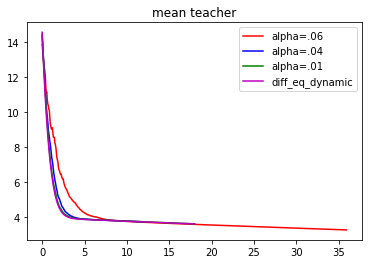

In [42]:
plt.plot(x_scale(.06, len(minibatch_gen_error_mt)), minibatch_gen_error_mt, color = "r",label="alpha=.06")
plt.plot(x_scale(.02, len(minibatch_gen_error_mt_lower)), minibatch_gen_error_mt_lower, color = "b", label="alpha=.04")
plt.plot(x_scale(.01, len(minibatch_gen_error_mt_lower2)), minibatch_gen_error_mt_lower2, color = "g", label="alpha=.01")
plt.plot(x_scale(.001, len(gen_error_diff_eq_mt)), gen_error_diff_eq_mt, color = "m", label="diff_eq_dynamic")

plt.legend()
plt.title("mean teacher")
plt.show()

In [70]:
scale_down = lambda x: [i/20 for i in x] 

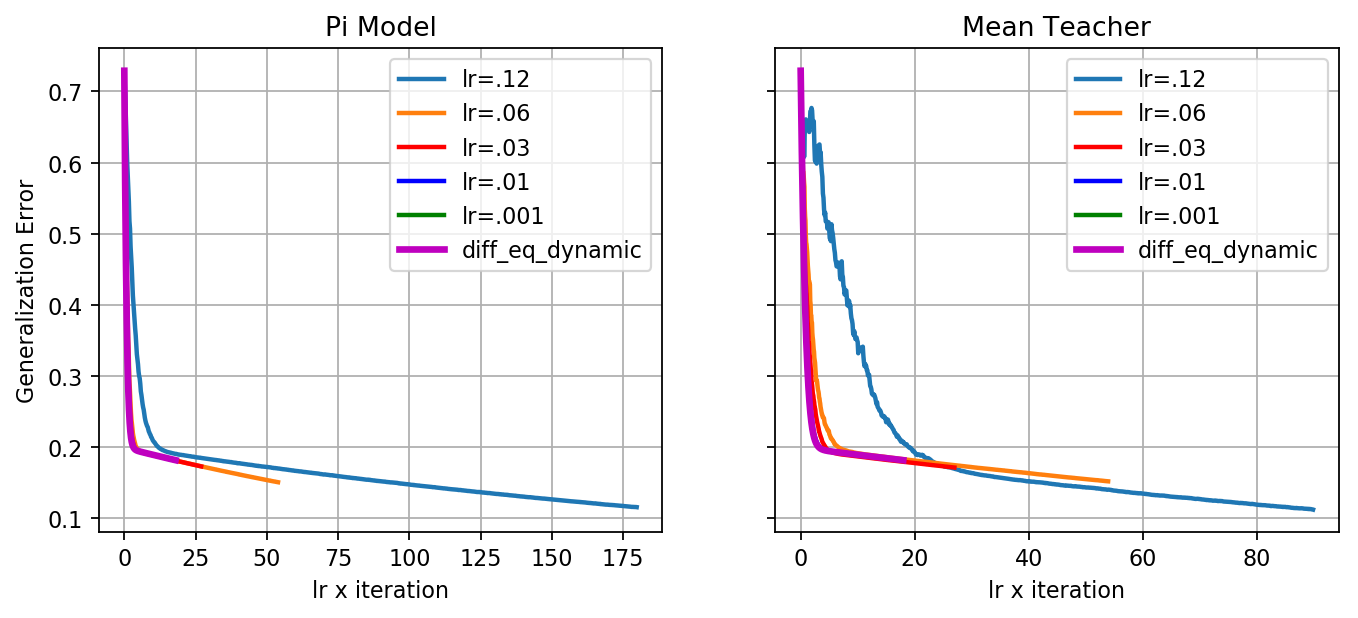

In [94]:
plt.rcParams.update({'font.size': 10})
f, axs = plt.subplots(1,2, figsize=(10,4), dpi=80, sharey='row')
ax = axs[0]
ax.plot(x_scale(.2, 900), scale_down(minibatch_gen_error_pi_very_high), label="lr=.12", linewidth=2)
ax.plot(x_scale(.06, len(minibatch_gen_error_pi_high)), scale_down(minibatch_gen_error_pi_high), label="lr=.06", linewidth=2)
ax.plot(x_scale(.03, len(minibatch_gen_error_pi)), scale_down(minibatch_gen_error_pi), color = "r", label="lr=.03", linewidth=2)
ax.plot(x_scale(.01, len(minibatch_gen_error_pi_lower)), scale_down(minibatch_gen_error_pi_lower), color = "b", label="lr=.01", linewidth=2)
ax.plot(x_scale(.001, len(minibatch_gen_error_pi_lower2)), scale_down(minibatch_gen_error_pi_lower2), color = "g", label="lr=.001", linewidth=2)
ax.plot(x_scale(.001, len(gen_error_diff_eq_pi)), scale_down(gen_error_diff_eq_pi), color = "m", label="diff_eq_dynamic", linewidth=3)
ax.grid(True)
ax.legend()
ax.set_ylabel('Generalization Error')
ax.set_xlabel('lr x iteration')
ax.set_title("Pi Model")
ax = axs[1]
ax.plot(x_scale(.1, 900), scale_down(minibatch_gen_error_mt_point2), label="lr=.12", linewidth=2)
ax.plot(x_scale(.06, len(minibatch_gen_error_mt_point06)), scale_down(minibatch_gen_error_mt_point06), label="lr=.06", linewidth=2)
ax.plot(x_scale(.03, len(minibatch_gen_error_mt_point03)), scale_down(minibatch_gen_error_mt_point03), color = "r", label="lr=.03", linewidth=2)
ax.plot(x_scale(.01, len(minibatch_gen_error_mt_point01)), scale_down(minibatch_gen_error_mt_point01), color = "b", label="lr=.01", linewidth=2)
ax.plot(x_scale(.001, len(minibatch_gen_error_mt_lower001)), scale_down(minibatch_gen_error_mt_lower001), color = "g", label="lr=.001", linewidth=2)
ax.plot(x_scale(.001, len(gen_error_diff_eq_mt)), scale_down(gen_error_diff_eq_mt), color = "m", label="diff_eq_dynamic", linewidth=3)
ax.grid(True)
ax.legend()
ax.set_xlabel('lr x iteration')
ax.set_title("Mean Teacher")


# plt.ylabel('Generalization Error')
# plt.tight_layout()
plt.savefig('sample.pdf')
plt.show()

In [ ]:
# # print("pi_model.........................................")
# # gen_error_pi, w_pi_list = pi_model(10000,.01)
# print("mean_teacher.....................................")
# gen_error_mt, w_mt_list = mean_teacher(10000,.1)

In [ ]:
# plt.plot(gen_error_pi)
# plt.plot(gen_error_mt, color="r")

In [ ]:
# w_pi_list[-1]

In [ ]:
# w_mt_list[-1]

In [ ]:
# true_w

In [ ]:
# w_first_element_pi = [w[0] for w in list_of_w_pi_eq]
# w_first_element_mt = [w[0] for w in list_of_w_mt_eq]
# plt.plot(w_first_element_pi[:10000])
# plt.plot(w_first_element_mt[:10000], color = "r")

In [ ]:
# plt.plot(gen_error_diff_eq_pi[:2000])
# plt.plot(gen_error_diff_eq_mt[:2000], color = "r")

In [ ]:
# plt.plot(gen_error_pi)
# plt.plot(gen_error_mt, color="r")

In [ ]:
# list_of_w_pi_eq[-1]

In [ ]:
# list_of_w_mt_eq[-1]